In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

# Overfitting vs underfitting

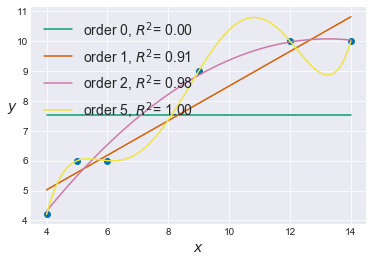

In [2]:
x = np.array([4.,5.,6.,9.,12, 14.])
y = np.array([4.2, 6., 6., 9., 10, 10.])

order = [0, 1, 2, 5]
plt.plot(x, y, 'o')
for i in order:
    x_n = np.linspace(x.min(), x.max(), 100)
    coeffs = np.polyfit(x, y, deg=i)
    ffit = np.polyval(coeffs, x_n)
    
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.mean(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2) 
    r2 = ssreg / sstot

    plt.plot(x_n, ffit, label='order {}, $R^2$= {:.2f}'.format(i, r2))

plt.legend(loc=2, fontsize=14)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14, rotation=0)
plt.savefig('B04958_06_01.png', dpi=300, figsize=[5.5, 5.5])
#plt.plot([10, 7], [9, 7], 's')
#plt.savefig('B04958_06_02.png', dpi=300, figsize=[5.5, 5.5])

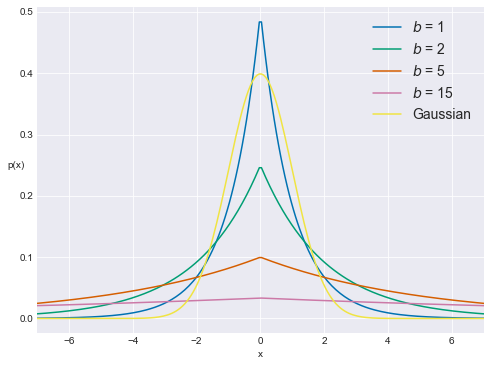

In [3]:
plt.figure(figsize=(8, 6))
x_values = np.linspace(-10, 10, 300)
for df in [1, 2, 5, 15]:
    distri = stats.laplace(scale=df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label='$b$ = {}'.format(df))

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, label='Gaussian')
plt.xlabel('x')
plt.ylabel('p(x)', rotation=0)
plt.legend(loc=0, fontsize=14)
plt.xlim(-7, 7);
plt.savefig('B04958_06_03.png', dpi=300, figsize=[5.5, 5.5])

In [4]:
x_1 = np.array([ 10.,   8.,  13.,   9.,  11.,  14.,   6.,   4.,  12.,   7.,   5.])
y_1 = np.array([  8.04,   6.95,   7.58,   8.81,   8.33,   9.96,   7.24,   4.26,
        10.84,   4.82,   5.68])

In [5]:
np.random.seed(1)
real_alpha = 4.25
real_beta = [8.7, -1.2]
data_size = 20
noise = np.random.normal(0, 2, size=data_size)
x_1 = np.linspace(0, 5, data_size)
y_1 = real_alpha + real_beta[0] * x_1 + real_beta[1] * x_1**2 + noise

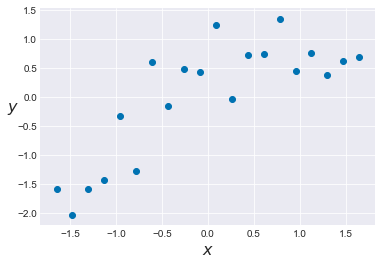

In [6]:
order = 2#5
x_1p = np.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True))/x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean())/y_1.std()
plt.scatter(x_1s[0], y_1s)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.savefig('B04958_06_04.png', dpi=300, figsize=[5.5, 5.5])

In [7]:
with pm.Model() as model_l:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + beta * x_1s[0]
    
    y_l = pm.Normal('y_l', mu=mu, sd=epsilon, observed=y_1s)
    
    trace_l = pm.sample(2100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 99%|█████████▉| 2585/2600 [00:04<00:00, 601.19it/s]/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.880563879235, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 2600/2600 [00:04<00:00, 544.12it/s]


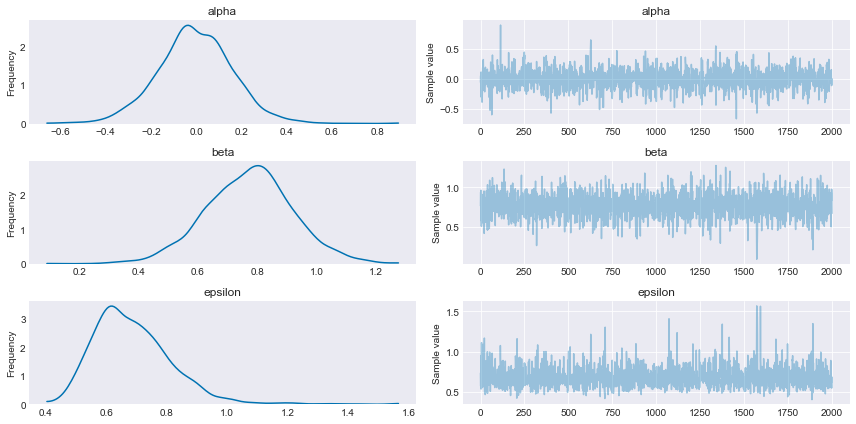

In [8]:
chain_l = trace_l[100:]
pm.traceplot(chain_l);

In [9]:
pm.df_summary(chain_l)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-0.004244,0.163702,0.004381,-0.349539,0.294595
beta,0.770204,0.148279,0.003150,0.486822,1.071365
epsilon,0.689603,0.131352,0.003605,0.477251,0.926601


In [10]:
with pm.Model() as model_p:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=x_1s.shape[0])  
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + pm.math.dot(beta, x_1s)
    
    y_l = pm.Normal('y_l', mu=mu, sd=epsilon, observed=y_1s)
    
    trace_p = pm.sample(2100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2600/2600 [00:08<00:00, 319.43it/s]


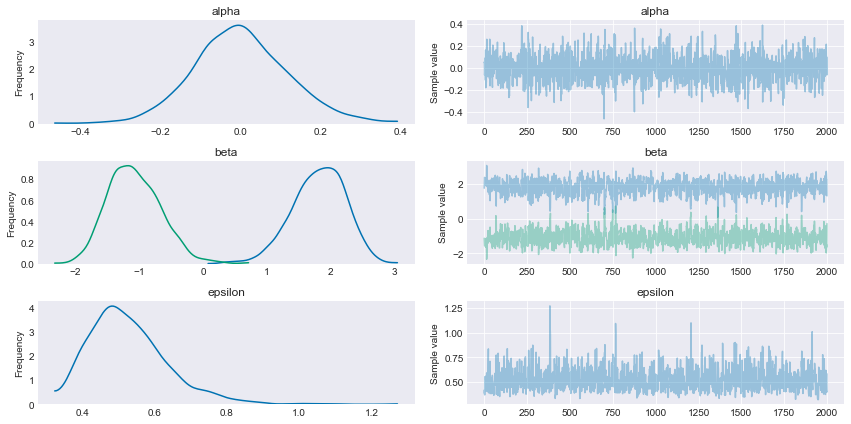

In [11]:
chain_p = trace_p[100:]
pm.traceplot(chain_p);

In [12]:
pm.df_summary(chain_p)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-0.001276,0.117703,0.003186,-0.228180,0.234964
beta__0,1.811204,0.419178,0.014893,0.962045,2.554436
beta__1,-1.082785,0.417756,0.014677,-1.818645,-0.248629
epsilon,0.528775,0.109199,0.003483,0.342695,0.743862


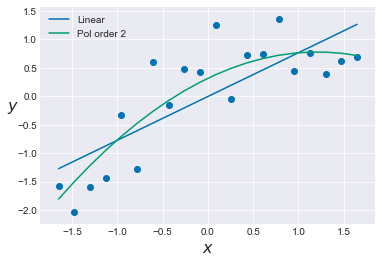

In [13]:
alpha_l_post = chain_l['alpha'].mean()
betas_l_post = chain_l['beta'].mean(axis=0)
idx = np.argsort(x_1s[0])
y_l_post = alpha_l_post + betas_l_post * x_1s[0]

plt.plot(x_1s[0][idx], y_l_post[idx], label='Linear')


alpha_p_post = chain_p['alpha'].mean()
betas_p_post = chain_p['beta'].mean(axis=0)
y_p_post = alpha_p_post + np.dot(betas_p_post, x_1s)

plt.plot(x_1s[0][idx], y_p_post[idx], label='Pol order {}'.format(order))

plt.scatter(x_1s[0], y_1s)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0);
plt.legend()
plt.savefig('B04958_06_05.png', dpi=300, figsize=[5.5, 5.5])

# Information criteria

In [14]:
dic_l = pm.dic(trace=trace_l, model=model_l)
dic_l

57.110162601359562

In [15]:
dic_p = pm.dic(trace=trace_p, model=model_p)
dic_p

54.009061108709005

In [16]:
waic_l = pm.waic(trace=trace_l, model=model_l)
waic_l

WAIC_r(WAIC=42.63685336301689, WAIC_se=4.1147004546641979, p_WAIC=2.1340394607818061)

In [17]:
waic_p = pm.waic(trace=trace_p, model=model_p)
waic_p

WAIC_r(WAIC=32.596020326282591, WAIC_se=4.6083454909416321, p_WAIC=2.6604393741122228)

In [18]:
loo_l = pm.loo(trace=trace_l, model=model_l)
loo_l

/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/stats.py:285: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is
        because importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


LOO_r(LOO=42.832430745953701, LOO_se=4.1744217194583966, p_LOO=2.231828152250209)

In [19]:
loo_p = pm.loo(trace=trace_p, model=model_p)
loo_p

/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/stats.py:285: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is
        because importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


LOO_r(LOO=32.851672728510657, LOO_se=4.6789669889326557, p_LOO=2.7882655752262551)

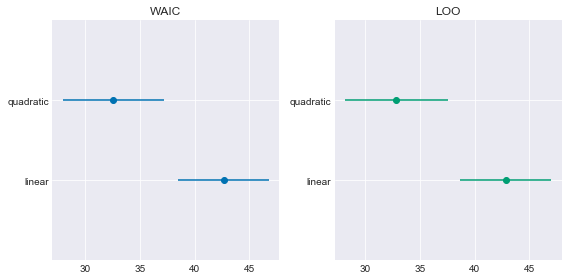

In [20]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
for idx, ic in enumerate((waic_l, waic_p)):
    plt.errorbar(ic[0], idx, xerr=ic[1], fmt='C0o')
plt.title('WAIC')
plt.yticks([0, 1], ['linear', 'quadratic'])
plt.ylim(-1, 2)

plt.subplot(122)
for idx, ic in enumerate((loo_l, loo_p)):
    plt.errorbar(ic[0], idx, xerr=ic[1], fmt='C1o')
plt.title('LOO')
plt.yticks([0, 1], ['linear', 'quadratic'])
plt.ylim(-1, 2)

plt.tight_layout()

plt.savefig('B04958_06_06.png', dpi=300, figsize=[5.5, 5.5])

## Posterior predictive checks

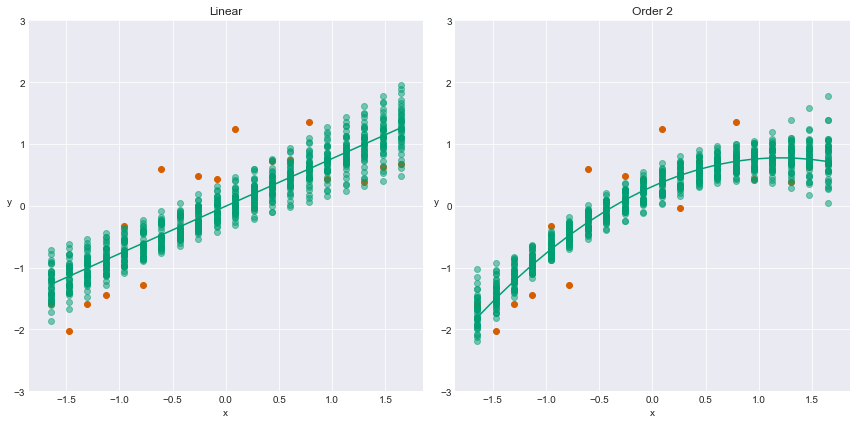

In [21]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(x_1s[0], y_1s, c='C2');
plt.ylim(-3, 3)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.title('Linear')


for i in range(0, len(chain_l['alpha']), 50):
    plt.scatter(x_1s[0], chain_l['alpha'][i] + chain_l['beta'][i]*x_1s[0], c='C1',
                edgecolors='C1', alpha=0.5);
plt.plot(x_1s[0], chain_l['alpha'].mean() + chain_l['beta'].mean()*x_1s[0], c='C1', alpha=1)

    
plt.subplot(122)
plt.scatter(x_1s[0], y_1s, c='C2');
plt.ylim(-3, 3)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.title('Order {}'.format(order))
for i in range(0, len(chain_p['alpha']), 50):
    plt.scatter(x_1s[0], chain_p['alpha'][i] + np.dot(chain_p['beta'][i], x_1s), c='C1',
                edgecolors='C1', alpha=0.5)
idx = np.argsort(x_1)
plt.plot(x_1s[0][idx], alpha_p_post + np.dot(betas_p_post, x_1s)[idx], c='C1', alpha=1);

plt.tight_layout()
plt.savefig('B04958_06_07.png', dpi=300, figsize=[5.5, 5.5])

# Bayes factors

In [22]:
coins = 30 # 300
heads = 9 # 90
y_d = np.repeat([0, 1], [coins-heads, heads])

In [23]:
with pm.Model() as model_BF:
    p = np.array([0.5, 0.5])
    model_index = pm.Categorical('model_index', p=p)
    
    m_0 = (4, 8)
    m_1 = (8, 4)
    m = pm.math.switch(pm.math.eq(model_index, 0), m_0, m_1)

    # a priori
    theta = pm.Beta('theta', m[0], m[1])
    # likelihood
    y = pm.Bernoulli('y', theta, observed=y_d)
     
    trace_BF = pm.sample(5000)

Assigned BinaryGibbsMetropolis to model_index
Assigned NUTS to theta_logodds__
100%|██████████| 5500/5500 [00:10<00:00, 536.55it/s]


0.916222222222 0.0837777777778 10.9363395225


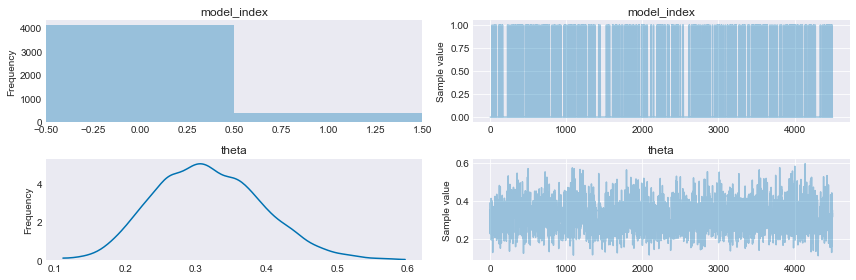

In [24]:
chain_BF = trace_BF[500:]
pm.traceplot(chain_BF)
pM1 = chain_BF['model_index'].mean()
pM0 = 1 - pM1
print(pM0, pM1, (pM0/pM1)*(p[1]/p[0]))
plt.savefig('B04958_06_09.png', dpi=300, figsize=[5.5, 5.5])

In [25]:
with pm.Model() as model_BF_0:
    theta = pm.Beta('theta', 4, 8)
    y = pm.Bernoulli('y', theta, observed=y_d)
    
    trace_BF_0 = pm.sample(5000)  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5500/5500 [00:04<00:00, 1289.05it/s]


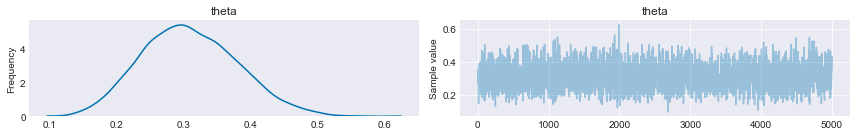

In [26]:
chain_BF_0 = trace_BF_0[500:]
pm.traceplot(trace_BF_0)
plt.savefig('B04958_06_10.png', dpi=300, figsize=[5.5, 5.5])

In [27]:
with pm.Model() as model_BF_1:
    theta = pm.Beta('theta', 8, 4)
    y = pm.Bernoulli('y', theta, observed=y_d)
    
    trace_BF_1 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5500/5500 [00:04<00:00, 1282.50it/s]


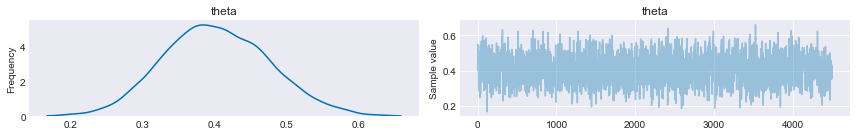

In [28]:
chain_BF_1 = trace_BF_1[500:]
pm.traceplot(chain_BF_1)
plt.savefig('B04958_06_11.png', dpi=300, figsize=[5.5, 5.5])

In [29]:
waic_0 = pm.waic(chain_BF_0, model_BF_0)
waic_0

WAIC_r(WAIC=38.143654628842029, WAIC_se=4.2458119925525404, p_WAIC=0.73906083559560831)

In [30]:
waic_1 = pm.waic(chain_BF_1, model_BF_1)
waic_1

WAIC_r(WAIC=39.318367368659857, WAIC_se=2.0724018197267222, p_WAIC=0.64911793478752855)

In [31]:
loo_0 = pm.loo(chain_BF_0, model_BF_0)
loo_0

/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/stats.py:285: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is
        because importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


LOO_r(LOO=38.165591950372466, LOO_se=4.2499266980442822, p_LOO=0.75002949636082406)

In [32]:
loo_1 = pm.loo(chain_BF_1, model_BF_1)
loo_1

/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/stats.py:285: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is
        because importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


LOO_r(LOO=39.334613338323095, LOO_se=2.074033299157009, p_LOO=0.65724091961914866)

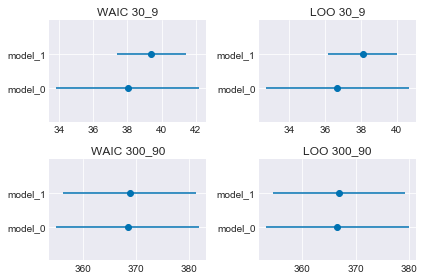

In [35]:
est = [((38.02, 4.17), (39.41, 2.04)), ((36.69, 3.96), (38.09, 1.94)),
       ((368.41, 13.40), (368.76, 12.48)) , ((366.61, 13.31), (366.87, 12.34))]

title = ['WAIC 30_9', 'LOO 30_9', 'WAIC 300_90', 'LOO 300_90']

for i in range(4):
    plt.subplot(2,2,i+1)
    for idx, ic in enumerate(est[i]):
        plt.errorbar(ic[0], idx, xerr=ic[1], fmt='C0o')
    plt.title(title[i])
    plt.yticks([0, 1], ['model_0', 'model_1'])
    plt.ylim(-1, 2)

plt.tight_layout()

plt.savefig('B04958_06_12.png', dpi=300, figsize=[5.5, 5.5])

In [34]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was created on a %s computer running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

This notebook was created on a x86_64 computer running debian stretch/sid and using:
Python 3.6.2
IPython 6.1.0
PyMC3 3.2
NumPy 1.13.1
SciPy 0.19.1
Matplotlib 2.0.2
Seaborn 0.8.0
